Reading the GeoTIFF as a plain image, not caring about the georeference for now

In [66]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # Disable warnings for pillow DecompressionBombError

im = Image.open('popsub.tif')

Convert to numpy array

In [67]:
import numpy as np
raster = np.array(im)
raster.shape

(183, 326)

Let's take a subset of the 2D array to keep things manageable

In [68]:
raster = raster[0:300,0:300]
raster.shape

(183, 300)

Plot with matplotlib

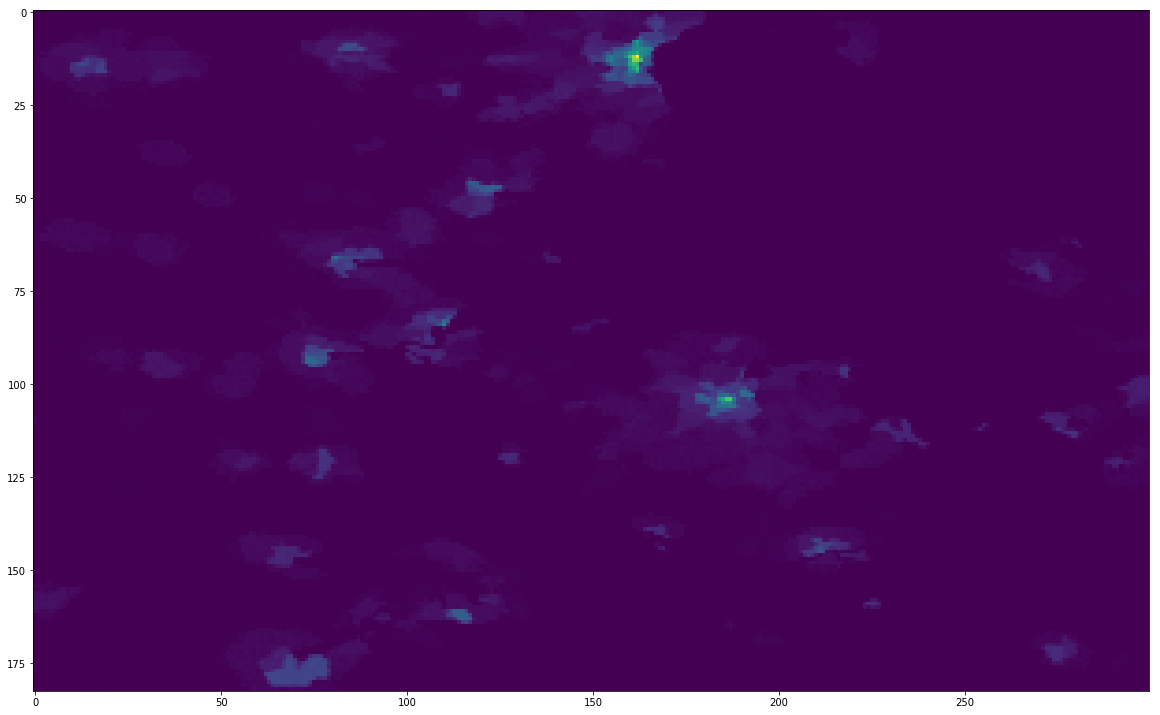

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# make the inline image outputs larger
mpl.rcParams['figure.figsize'] = (20,20)
plt.imshow(raster)

In [70]:
numpoints = np.sum(raster)
points = np.zeros((numpoints,2), dtype=int)
points

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [71]:
%%timeit
point = 0
for r in range(0, raster.shape[0]):
    for c in range(0, raster.shape[1]):
        # create a n points for number n in the raster cell:
        for n in range(0, raster[r,c]):
            points[point,0] = r
            points[point,1] = c
            point = point + 1

622 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using numpy's [nditer](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.nditer.html#tracking-an-index-or-multi-index) and [append](https://docs.scipy.org/doc/numpy/reference/generated/numpy.append.html) - see also the [Minimal Example notebook](Minimal%20Example.ipynb).

Let's see what's faster:

In [72]:
%%timeit
# make an empty 2D "target array"
points = np.zeros((numpoints,2), dtype=int)

# keep track of where in the target array we have to insert
insertrow = 0

# iterate over the input raster
it = np.nditer(raster, flags=['multi_index'])
while not it.finished:
    entry = np.array([np.array(it.multi_index)])
    block = np.repeat(entry, it[0], axis=0)
    points[insertrow:insertrow+block.shape[0]] = block
    insertrow = insertrow + block.shape[0]
    it.iternext()

274 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
points

array([[  0,   0],
       [  0,   0],
       [  0,   0],
       ...,
       [182, 296],
       [182, 298],
       [182, 298]])

In [74]:
points.size

3806024

Next, we will randomly move each point around within its cell. We can also choose to keep the "edges" between the cells (set expansion to < 1.0) or allow the points to go outside the cells, which "softenes" the edges, giving the impression of a more smooth surface (set expansion to > 1.0)

In [75]:
expansion = 0.95

seed = np.random.rand(numpoints,2)
seed = seed * expansion

plot = points + seed

Plot:

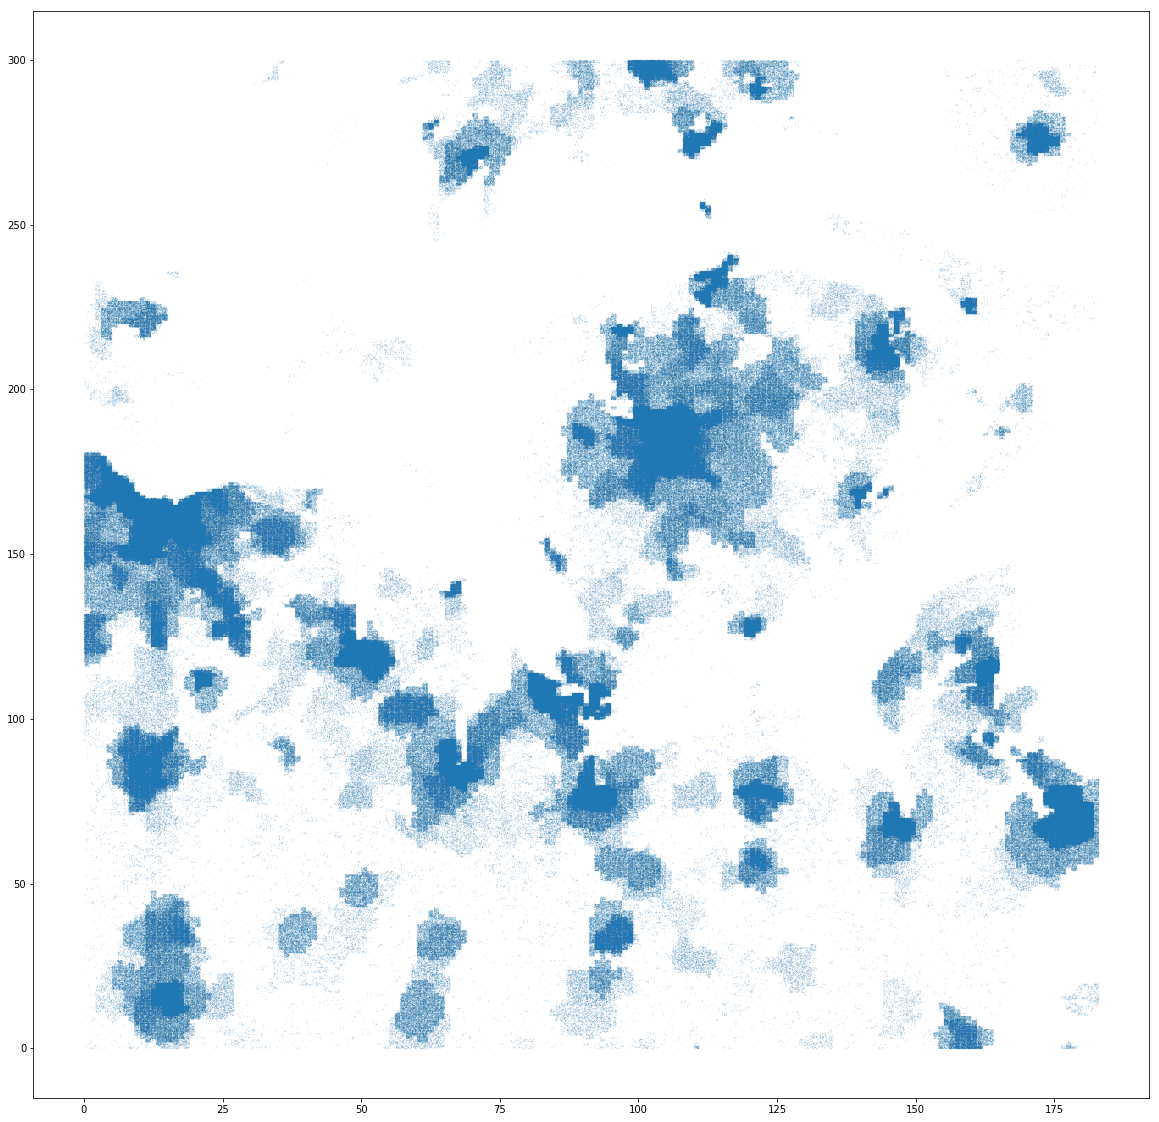

In [76]:
plt.scatter(plot[:,0], plot[:,1], s=0.01, alpha=0.5)
plt.show()